In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import CIFAR10
from torchvision import transforms


from torchinfo import summary

np.random.seed(0)
torch.manual_seed(0)

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.cuda.empty_cache()

Using cuda device


In [3]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms.functional as pil_torch



class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.data_classes = self.image_folder
        self.transform = transform
        self.featureExtraction = featureExtraction
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        # print("getitem",type(image))
        classes = self.data_classes.classes[label]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        # apply featrue extract
        if self.featureExtraction:
            imagePil = pil_torch.to_pil_image(image)
            depth = self.featureExtraction(imagePil)
            imCat = torch.cat((image, depth))

        
        
        
        varReturn = {
            "image": image,
            "depth": depth,
            "label": label,
            "imcat": imCat,
            "classes": classes,
            
        }
        
        
        
        return varReturn

In [4]:
import torchvision.transforms.functional as pil_torch

def rgbd_feature(img):
    im = img
    # print(type(im))
    predict = pipe(img)
    predict = predict['predicted_depth']
    predict = predict.unsqueeze(0)
    return predict.cpu()

In [5]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
    #  transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../../../dataset/hagrid/hagrid-min/", transform=train_transform, featureExtraction=rgbd_feature)

print(type(dataset))

<class '__main__.dawtaset'>


In [6]:
from torch.utils.data import DataLoader, random_split
BATCH_SIZE = 32
# split dataset
train_data, val_data = random_split(dataset, [0.70, 0.30])


train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    


In [7]:
from transformers import pipeline
import torch
from accelerate.test_utils.testing import get_backend
device, _, _ = get_backend()
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint, device=device)


Device set to use cuda


In [8]:
import timm

PATCH_SIZE = 10
IMAGE_WIDTH = 100
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 4
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)


print(EMBEDDING_DIMS)

BATCH_SIZE = 32

BATCH_SIZE = 32
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        # print(x.shape)
        # print(self.class_token_embeddings.shape)
        # print(self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))).shape)
        # print(self.position_embeddings.shape)
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output
      
# multihead attention
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = EMBEDDING_DIMS, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output


class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))
  


class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = EMBEDDING_DIMS,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3000,
               num_heads = 10,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x
  

class ViT(nn.Module):
  def __init__(self, img_size = 100,
               in_channels = 4,
               patch_size = 10,
               embedding_dims = EMBEDDING_DIMS,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3000,
               num_heads = 10,
               num_classes = 18):
    super().__init__()
    
    
    

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))
    self.attention_weights = []
  

  def forward(self, x):
    # im_rgbd = self.rgbd(x)
    # print(x.shape)
    # x1 = self.patch_embedding_layer(x)
    # for transformer_block in self.transformer_encoder:
    #   x1, attn_weights = transformer_block(x1) # Get weights from each block
    #   self.attention_weights.append(attn_weights) 
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])
  


vit = ViT(img_size = 100,
               in_channels = 4,
               patch_size = 10,
               embedding_dims = EMBEDDING_DIMS,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 10,
               num_classes = 27
          )


400


In [9]:
summary(model=vit,
        input_size=(BATCH_SIZE, 4, 100, 100), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 4, 100, 100]    [32, 27]             --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [32, 4, 100, 100]    [32, 101, 400]       53,200               True
│    └─Conv2d (conv_layer)                                   [32, 4, 100, 100]    [32, 400, 10, 10]    160,400              True
│    └─Flatten (flatten_layer)                               [32, 10, 10, 400]    [32, 100, 400]       --                   --
├─Sequential (transformer_encoder)                           [32, 101, 400]       [32, 101, 400]       --                   True
│    └─TransformerBlock (0)                                  [32, 101, 400]       [32, 101, 400]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [32, 101, 400]       [32, 101, 40

In [10]:
device = torch.device("cuda")
path_model = 'model_hagrid_vit_monocular'
vit.load_state_dict(torch.load(path_model, weights_only=True, map_location="cuda:0"))
vit.to(device)

ViT(
  (patch_embedding_layer): PatchEmbeddingLayer(
    (conv_layer): Conv2d(4, 400, kernel_size=(10, 10), stride=(10, 10))
    (flatten_layer): Flatten(start_dim=1, end_dim=2)
  )
  (transformer_encoder): Sequential(
    (0): TransformerBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (multiheadattention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=400, out_features=400, bias=True)
        )
      )
      (mlp_block): MachineLearningPerceptronBlock(
        (layernorm): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=400, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=400, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): Transform

In [11]:
image_test="../../../dataset/hagrid/hagrid-min/call/ef12e399-d421-411d-a970-08ad95a805fc.jpeg"



In [12]:
feats = {} 

def get_activation(name):
    def hook_func(module, input, output):
        feats[name] = output.detach()

In [21]:
# model_to_hook = vit.transformer_encoder

# model_to_hook.register_forward_hook(hook_func)


for name, module in vit.transformer_encoder:
    # You can specify which layers to hook based on their name or type
    if isinstance(module, nn.Linear):  # Example: hook all linear layers
        module.register_forward_hook(get_activation(name))

TypeError: cannot unpack non-iterable TransformerBlock object

In [14]:
tesImage = dataset[22510]['imcat']
print(tesImage.shape)


torch.Size([4, 100, 100])


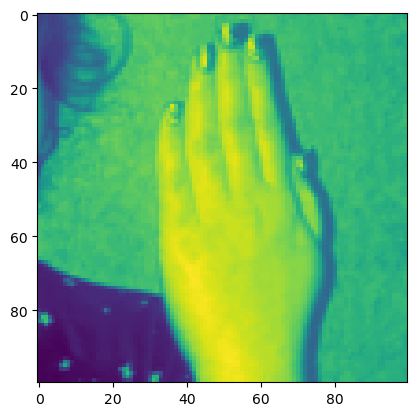

In [15]:
import matplotlib.pyplot as plt

plt.imshow(tesImage.numpy()[0])

In [16]:
desired_batch_size = 32
tesImage = tesImage.unsqueeze(0)
print(tesImage.shape)
repeated_tensor = tesImage.repeat(desired_batch_size, 1, 1, 1) #repeat the tensor 32 times in the batch dimension
reshaped_tensor = repeated_tensor.reshape(desired_batch_size, 4, 100, 100) #reshape the tensor
print("Reshaped tensor shape:", reshaped_tensor.shape)

torch.Size([1, 4, 100, 100])
Reshaped tensor shape: torch.Size([32, 4, 100, 100])


In [17]:
output = vit(reshaped_tensor.cuda())
print(output)

tensor([[ 3.2558e+00,  1.5050e+00, -2.5822e+00, -4.8587e+00,  1.0763e+00,
         -2.7089e-01, -6.5025e+00, -4.2970e+00, -1.3365e+00, -1.0970e+01,
          3.2074e+00, -1.1059e+01,  6.7163e+00,  2.4385e+01, -7.8828e+00,
         -7.8312e+00,  5.0313e-01,  1.2845e+01,  1.5184e+00,  2.4005e+00,
          5.1726e+00,  9.2974e-02, -1.1598e+00,  4.4064e-01,  2.8465e-01,
          8.9930e-01, -8.5357e-01],
        [ 3.0814e+00,  1.1975e+00, -2.2182e+00, -4.4330e+00,  1.9758e+00,
         -7.1442e-01, -6.5481e+00, -3.3688e+00, -1.6154e+00, -1.1648e+01,
          1.9359e+00, -1.0736e+01,  6.3063e+00,  2.4601e+01, -7.8337e+00,
         -8.2212e+00,  1.1818e+00,  1.3096e+01,  1.6564e+00,  2.2821e+00,
          5.2147e+00,  2.8206e-01, -1.2628e+00,  3.4514e-01, -8.7246e-02,
          7.5439e-01, -7.7425e-01],
        [ 3.4673e+00,  9.7544e-01, -2.3444e+00, -4.2581e+00,  1.5360e+00,
         -1.0113e+00, -6.0211e+00, -4.6098e+00, -5.0684e-01, -1.1025e+01,
          2.0843e+00, -1.0675e+01,  6.09

In [19]:
print(feats)

{}


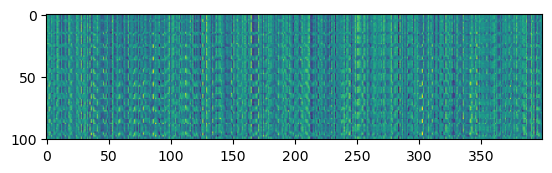

In [ ]:
plt.imshow(feats['feat'].cpu().numpy()[31])